# Register my own dataset with the Detectron2 format

In [1]:
import os
from detectron2.data import DatasetCatalog, MetadataCatalog, DatasetMapper, build_detection_train_loader, build_detection_test_loader
from dataset_utils import get_data_dicts, load_mask_data
from detectron2.data.datasets import register_coco_instances, convert_to_coco_json
import matplotlib.pyplot as plt

DATA_DIR = './dl_challenge_copy'

# Call the function to register the dataset.
for d in ["train", "val", "test"]:
    DatasetCatalog.register(f"custom_dataset_{d}", 
        lambda d=d: get_data_dicts(os.path.join(DATA_DIR, d)))
    
    # Set metadata for the dataset. "thing_classes" specifies the object categories.
    # Since we only have one category ("object"), we define this here.
    MetadataCatalog.get(f"custom_dataset_{d}").set(thing_classes=["object"])
    json_ann_file = os.path.join(DATA_DIR, d + '.json') 
    convert_to_coco_json(f"custom_dataset_{d}", json_ann_file, allow_cached=False)
    register_coco_instances(f"custom_dataset_{d}", {}, json_ann_file, DATA_DIR)
    print(f"Registered dataset {d}")

Registered dataset train
Registered dataset val
Registered dataset test


To verify the dataset is in correct format, let's visualize the annotations of some samples in the training set:

{'file_name': './dl_challenge_copy/train/859074c2-9915-11ee-9103-bbb8eae05561/rgb.jpg', 'image_id': 0, 'height': 451, 'width': 706, 'annotations': [{'segmentation': [[444, 207, 444, 234, 445, 235, 445, 236, 444, 237, 443, 236, 442, 236, 440, 234, 439, 234, 437, 232, 436, 232, 434, 230, 433, 230, 431, 228, 430, 228, 428, 226, 427, 226, 425, 224, 424, 224, 422, 222, 421, 222, 419, 220, 418, 220, 416, 218, 415, 218, 413, 216, 412, 216, 410, 214, 409, 214, 410, 215, 410, 218, 411, 219, 411, 221, 412, 222, 412, 225, 413, 226, 413, 229, 414, 230, 414, 233, 415, 234, 415, 236, 416, 237, 416, 240, 417, 241, 417, 244, 419, 246, 420, 246, 421, 247, 423, 247, 424, 248, 425, 248, 426, 249, 427, 249, 428, 250, 429, 250, 430, 251, 431, 251, 432, 252, 433, 252, 435, 254, 436, 254, 439, 257, 440, 257, 444, 261, 443, 262, 431, 262, 430, 261, 426, 261, 425, 260, 423, 260, 422, 259, 421, 259, 422, 260, 422, 263, 423, 264, 423, 267, 424, 268, 424, 270, 425, 271, 425, 274, 426, 275, 426, 278, 427, 279, 427

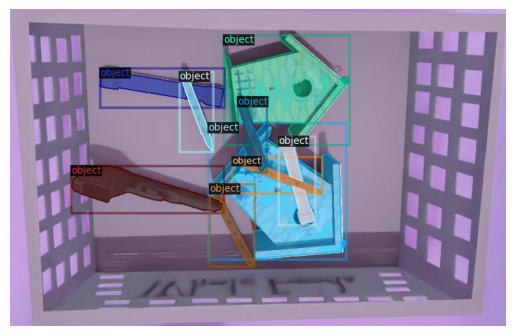

In [2]:
from visual_utils import visualize_n_annotations
visualize_n_annotations(DATA_DIR, "train", get_random=False, n_samples=1)

# Training

In [3]:
from my_det2 import *

cfg = get_custom_cfg(
    zoo_config_file = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
)

model = create_model(cfg)

print(f"Total number of parameters: {get_total_param_num_of_model(model):,}")

Using GPU
Total number of parameters: 43,918,038


In [4]:
print(cfg)
cfg.OUTPUT_DIR

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_SQRT: True
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('custom_dataset_train', 'custom_dataset_val')
  TRAIN: ('custom_dataset_train',)
FLOAT32_PRECISION: 
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: True
    SIZE: [0.8, 0.8]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_back

'./outputAUG'

In [5]:
from detectron2.data import transforms as T

train_transforms = [
    T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE),
    T.RandomFlip(horizontal=True, vertical=False),
    T.RandomFlip(vertical=True, horizontal=False),
    T.RandomRotation(angle=(-90,90)),
    T.ResizeShortestEdge(short_edge_length=cfg.INPUT.MIN_SIZE_TRAIN, 
                       max_size=cfg.INPUT.MAX_SIZE_TRAIN,
                      sample_style='choice'),
    # T.RandomBrightness(0.8, 1.8), # these make it worse
    # T.RandomContrast(0.6, 1.3),
    # T.RandomSaturation(0.6, 1.3),
    # T.RandomLighting(0.7),
]

In [6]:
from train_net import Trainer  # Import the custom trainer with evaluation.

# Add augmentations to the Trainer class.
class TrainerWithAugment(Trainer):
    @classmethod
    def build_train_loader(cls, cfg):
        recompute_boxes = cfg.MODEL.MASK_ON
     
        ret = {
            "is_train": True,
            "augmentations": train_transforms,
            "image_format": cfg.INPUT.FORMAT,
            "use_instance_mask": cfg.MODEL.MASK_ON,
            "instance_mask_format": cfg.INPUT.MASK_FORMAT,
            "use_keypoint": cfg.MODEL.KEYPOINT_ON,
            "recompute_boxes": recompute_boxes,
        }

        if cfg.MODEL.KEYPOINT_ON:
            ret["keypoint_hflip_indices"] = utils.create_keypoint_hflip_indices(cfg.DATASETS.TRAIN)

        if cfg.MODEL.LOAD_PROPOSALS:
            ret["precomputed_proposal_topk"] = (
                cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN
                if is_train
                else cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TEST
            )
        mapper = DatasetMapper(**ret)
        return build_detection_train_loader(cfg, mapper=mapper)

In [7]:
from detectron2.engine import DefaultTrainer
AUGMENTED = True
def train(cfg):
    if AUGMENTED:
        trainer = TrainerWithAugment(cfg)
    else:
        trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)  # Load from checkpoint if resuming training.
    trainer.train()  # Start training the model.

train(cfg)

[10/30 10:38:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[10/30 10:38:54 d2.engine.train_loop]: Starting training from iteration 0


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/30 10:38:59 d2.utils.events]:  eta: 0:09:16  iter: 19  total_loss: 2.644  loss_cls: 0.8069  loss_box_reg: 0.9  loss_mask: 0.6825  loss_rpn_cls: 0.1985  loss_rpn_loc: 0.04262    time: 0.1862  last_time: 0.2038  data_time: 0.0148  last_data_time: 0.0039   lr: 4.9952e-05  max_mem: 2442M


2024-10-30 10:39:00.502105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 10:39:00.550279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 10:39:00.564526: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 10:39:00.663632: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-30 10:39:01.730279: W tensorflow/compiler/tf2

[10/30 10:39:06 d2.utils.events]:  eta: 0:09:10  iter: 39  total_loss: 2.257  loss_cls: 0.5079  loss_box_reg: 0.904  loss_mask: 0.6145  loss_rpn_cls: 0.1136  loss_rpn_loc: 0.06437    time: 0.1863  last_time: 0.2270  data_time: 0.0040  last_data_time: 0.0038   lr: 9.9902e-05  max_mem: 2442M
[10/30 10:39:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/30 10:39:09 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/30 10:39:09 d2.data.common]: Serializing 140 elements to byte tensors and concatenating them all ...
[10/30 10:39:09 d2.data.common]: Serialized dataset takes 1.43 MiB
[10/30 10:39:09 d2.evaluation.evaluator]: Start inference on 140 batches
[10/30 10:39:10 d2.evaluation.evaluator]: Inference done 11/140. Dataloading: 0.0012 s/iter. Inference: 0.0631 s/iter. Eval: 0.0494 s/iter. Total: 0.1137 s/iter. ETA=0

# Evaluation

Using GPU
[10/30 11:05:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./outputAUG/model_final.pth ...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_lo

Processing image 1...
(519, 628, 3)


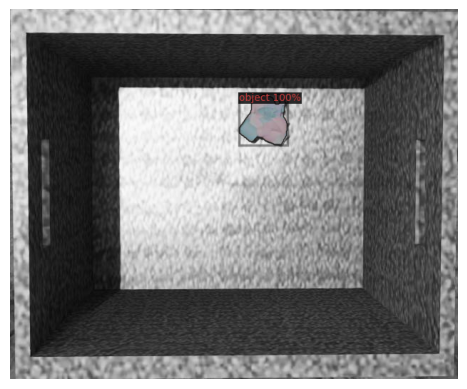

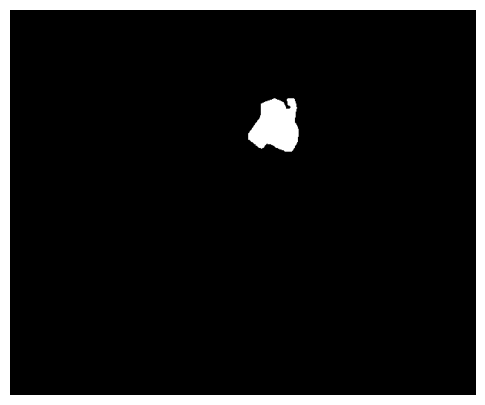

Processing image 2...
(596, 727, 3)


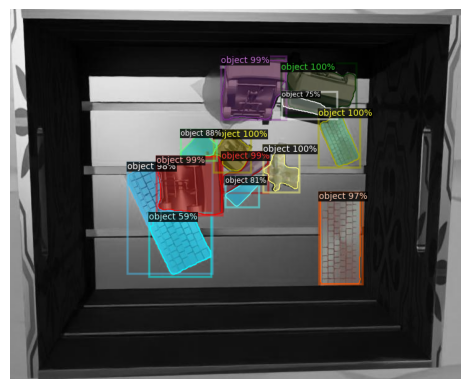

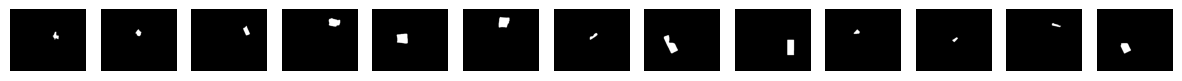

Processing image 3...
(573, 788, 3)


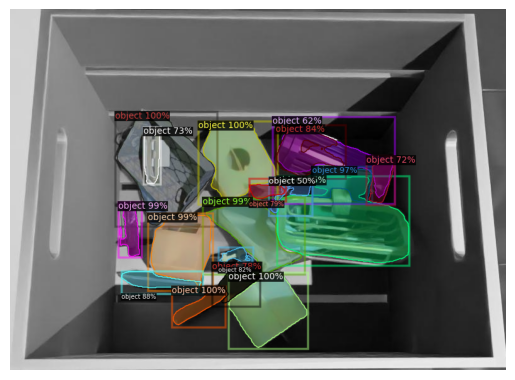

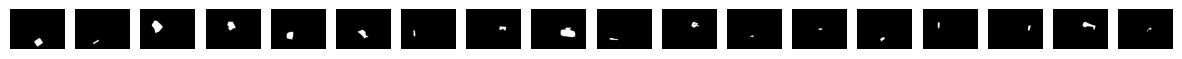

In [8]:
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
import cv2

from dataset_utils import get_data_dicts
from utils import cv2_imshow
from my_det2 import *
from visual_utils import print_masks

def predict_and_save_masks(dataset_dicts, predictor, object_metadata, 
    OUTPUT_DIR, N=3, VISUALIZE=True, SAVE=False):
    """
    This function takes a list of dataset dictionaries, a predictor object, and other parameters.
    It loops over the dataset and makes predictions using the predictor object.
    It can optionally save the predictions as mask.npy files and visualize the results.
    """

    # Loop over dataset_dicts, but limit the loop to N iterations
    for idx, d in enumerate(dataset_dicts):
    # for idx, d in enumerate(random.sample(dataset_dicts, 3)):
        if idx >= N:
            break  # Stop the loop after N iterations
        print(f"Processing image {idx + 1}...")
        
        im = cv2.imread(d["file_name"])
        print(im.shape)
        outputs = predictor(im)

        if SAVE:
            # Extract instance masks from the output
            instances = outputs["instances"].to("cpu")
            masks = instances.pred_masks.numpy()  # (num_instances, height, width)
            
            # Ensure masks are boolean
            masks = masks.astype(bool)
            
            # Save the masks as a boolean mask.npy file
            example_folder = os.path.basename(os.path.dirname(d["file_name"]))  # Get the current example folder name
            output_example_folder = os.path.join(OUTPUT_DIR, example_folder)
            
            # Create the folder if it doesn't exist
            os.makedirs(output_example_folder, exist_ok=True)
            
            # Save the RGB image (you can overwrite or save a new copy)
            rgb_output_path = os.path.join(output_example_folder, 'rgb.jpg')
            cv2.imwrite(rgb_output_path, im)  # Save the original image
            
            # Save the boolean mask numpy array
            mask_output_path = os.path.join(output_example_folder, 'mask.npy')
            np.save(mask_output_path, masks)  # Save the boolean mask array as mask.npy
            print(f"Saved mask to {mask_output_path}")
        
        if VISUALIZE:
            v = Visualizer(im[:, :, ::-1],
                        metadata=object_metadata,
                        scale=1,
                        instance_mode=ColorMode.IMAGE_BW  # Remove the colors of unsegmented pixels
                        )
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            
            cv2_imshow(v.get_image()[:, :, ::-1])  # Display the image

            print_masks(outputs)

# Prepare the trained model
cfg = get_custom_cfg(zoo_config_file = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the confidence threshold for predictions (between 0 and 1).

predict_and_save_masks(
    dataset_dicts = get_data_dicts(os.path.join(DATA_DIR, "test")), 
    predictor=DefaultPredictor(cfg),  # Create a predictor object using the configuration. 
    object_metadata = MetadataCatalog.get("custom_dataset_test"), 
    OUTPUT_DIR = "./dl_predictions/test", 
    N=3, 
    VISUALIZE=True, 
    SAVE=False)


now print some evaluation metrics

In [3]:
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os
import torch
from my_det2 import *
from utils import print_ordered_dict_results

def eval_model(cfg, weights_path = "output/model_final.pth", confidence_threshold = 0.7):
    cfg.MODEL.WEIGHTS = weights_path  # Load the trained model weights
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold  # Set the confidence threshold for predictions

    # Create a predictor to load the trained model
    predictor = DefaultPredictor(cfg)

    # Create the COCOEvaluator and data loader for the test set
    evaluator = COCOEvaluator("custom_dataset_test", distributed=False, output_dir="./eval_test_output/")
    test_loader = build_detection_test_loader(cfg, "custom_dataset_test")

    # Run the evaluation and print the results
    print("Starting evaluation on the test set...")
    evaluation_results = inference_on_dataset(predictor.model, test_loader, evaluator)

    print_ordered_dict_results(evaluation_results)

cfg = get_custom_cfg(zoo_config_file = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")


Using GPU


## Without transforms
Segmentation Results (segm):
  - Average Precision (AP): 45.11
    * AP is the average precision across all IoU thresholds from 0.50 to 0.95.
    This is considered good performance.
  - Average Precision at IoU=0.50 (AP50): 62.37
    * AP50 is the precision at an IoU threshold of 0.50.
    This is considered excellent performance.
  - Average Precision at IoU=0.75 (AP75): 49.30
    * AP75 is the precision at an IoU threshold of 0.75.
    This is considered good performance.
  - Average Precision for small objects (APs): 8.61
    * APs evaluates the performance on small-sized objects.
    This is considered a lower performance and may need improvement.
  - Average Precision for medium objects (APm): 45.87
    * APm evaluates the performance on medium-sized objects.
    This is considered good performance.
  - Average Precision for large objects (APl): 81.30
    * APl evaluates the performance on large-sized objects.
    This is considered excellent performance.

In [6]:
# without transforms
eval_model(cfg, weights_path = f"output/model_final.pth")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_lo

Starting evaluation on the test set...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.667
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.547
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.593


## With transforms

Segmentation Results (segm):
  - Average Precision (AP): 46.10
    * AP is the average precision across all IoU thresholds from 0.50 to 0.95.
    This is considered good performance.
  - Average Precision at IoU=0.50 (AP50): 59.89
    * AP50 is the precision at an IoU threshold of 0.50.
    This is considered excellent performance.
  - Average Precision at IoU=0.75 (AP75): 50.52
    * AP75 is the precision at an IoU threshold of 0.75.
    This is considered excellent performance.
  - Average Precision for small objects (APs): 9.97
    * APs evaluates the performance on small-sized objects.
    This is considered a lower performance and may need improvement.
  - Average Precision for medium objects (APm): 46.53
    * APm evaluates the performance on medium-sized objects.
    This is considered good performance.
  - Average Precision for large objects (APl): 82.40
    * APl evaluates the performance on large-sized objects.
    This is considered excellent performance.

In [5]:
# with transforms
eval_model(cfg, weights_path = f"outputAUG/model_final.pth")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_lo

Starting evaluation on the test set...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.490
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.576
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.534
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.190
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.573
